<a href="https://colab.research.google.com/github/ariesslin/ie7500-g1-tweet-sentiment-nlp/blob/main/scripts/2.%20Data%20Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>2. Data Preprocessing</strong></h2>
  <p style="color:#333333;">Preparing data for model training and testing</p>
</div>

Raw tweet data is often noisy, inconsistent, and full of informal elements like emojis, mentions, hashtags, abbreviations, and inconsistent casing. Cleaning and standardizing this data is a critical step before any meaningful modeling can be done. Effective preprocessing not only improves model performance but also ensures that the insights learned from the data are robust and generalizable.

In this notebook, we apply a series of preprocessing steps tailored specifically to Twitter data, with the goal of simplifying the input while preserving sentiment-relevant patterns. The following steps will be applied to the Sentiment140 dataset:

- Convert all uppercase words to lowercase for consistency
- Replace all Twitter mentions (e.g., `@username`) with the token `"MENTION"` to retain structure without leaking identity-specific information
- Download necessary resources using `nltk.download()` (e.g., `stopwords`, `punkt`)
- Define a custom stopword list by combining standard NLTK stopwords with common punctuation marks (e.g., `,`, `.`, `"`, `'`)
- Remove extra white space and strip leading/trailing spaces

These steps help remove noise while preserving semantic structure, which is especially important for models like LSTM and BERT that are sensitive to input tokenization.

Finally, we will **split the dataset into training and testing subsets** to evaluate the models' generalization performance on unseen data.

This preprocessing pipeline prepares our dataset for vectorization and embedding, enabling classical models like Logistic Regression as well as deep learning architectures to learn from tweet text effectively.


<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>1. Data Loading & Overview</strong></h2>
  <p style="color:#333333;"></p>
</div>


In [1]:
# importing all libraries here
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import html
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import spacy
import string
import sys

In [2]:
sys.path.append("../utils")
from helper import load_sentiment140

In [3]:
# Step 1: Load Sentiment140 dataframe (modularized from EDA notebook)
df_fixed = load_sentiment140()

# Step 4: Fix any garbled characters in 'text' if needed
df_fixed["text"] = df_fixed["text"].apply(lambda x: x.encode("latin1").decode("utf-8", errors="ignore") if isinstance(x, str) else x)

# Step 5: Preview result
print(df_fixed["text"].head())

0    @switchfoot http://twitpic.com/2y1zl - Awww, t...
1    is upset that he can't update his Facebook by ...
2    @Kenichan I dived many times for the ball. Man...
3      my whole body feels itchy and like its on fire 
4    @nationwideclass no, it's not behaving at all....
Name: text, dtype: object


In [4]:
# we now decode HTML-escaped entities like &quot;, &amp;, etc.
df_fixed['text'] = df_fixed['text'].apply(lambda x: html.unescape(x) if isinstance(x, str) else x)


In [5]:
# Count how many tweets are longer than 140 characters

df_fixed['text_length'] = df_fixed['text'].apply(len)

num_long_tweets = df_fixed[df_fixed['text_length'] > 140].shape[0]
print(f"Number of tweets longer than 140 characters: {num_long_tweets}")

Number of tweets longer than 140 characters: 0


In [6]:
df_fixed['text'].apply(lambda x: pd.isna(x) or str(x).strip() == '').sum()


0

In [7]:
# Disable truncation in display
pd.set_option('display.max_colwidth', None)

# Sort by tweet length and show the top 10 longest tweets
df_fixed.sort_values(by='text_length', ascending=False)[['text', 'text_length']].head(10)

,text,text_length
1462693,"i am NOT liking the ""big-curly-hair-with-the-braids"" look :/ im not taking my braids out! i will just simply straighten my hair once more",138
1402277,Woke up to a storm outside...Florida gets on my nerves sometimes...the state not the lady from Good Times...except the episode when...nvm,138
1307540,"@ohmishka I thought it was such a great idea too, she said she would rather support independent artists than give her $ to big companies.",138
805844,"I like penis: Ok so backup only was not enough for you pussys, HERE, have some credit cards too You know, it'.. http://tinyurl.com/d356b3",138
805840,"Selling DILDO in a box: Ok so backup only was not enough for you pussys, HERE, have some credit cards too You.. http://tinyurl.com/ca2ecn",138
1111822,"http://twiturm.com/vew6 I made this mix just for fun. I used to live w/ 1 of the BCR (not as a bf) though in Lake Forest, CA. Trying ...",138
975039,"@chiropractic ha! you are my hero. weekend stats looking good over here, lots of people dreading their job come monday, searching 4 new 1",138
252190,Is finally back from London after being stuck in traffic for about 5 hours! I now have hardly any time to get work done. Long night ahead,138
626735,@brennygee Looks like the twitterverse disagrees with you I just figured my first iPod was white- I thought I'd be kicking it old school.,138
1307506,"yup its going to be @TaqiyyaLuvLa @10marion @officialTila @Tyrese4Real @Willie_Day26 @souljaboytellem and many more tonight,fun... lol jk",138


In [8]:
pd.reset_option('display.max_colwidth')

In [9]:
# Download the stopwords and punkt_tab
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ariesslin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ariesslin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 52.5 MB/s eta 0:00:00m eta 0:00:010:01:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [11]:
# step 1, Convert all cases to lower

tweets = df_fixed[['text', 'target']]

tweets['text'] = tweets['text'].str.lower()

tweets.head()

/var/folders/5m/q16b86r92zgbmjpxpdx4ghfw0000gn/T/ipykernel_3465/2406542833.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['text'] = tweets['text'].str.lower()


,text,target
0,"@switchfoot http://twitpic.com/2y1zl - awww, t...",0
1,is upset that he can't update his facebook by ...,0
2,@kenichan i dived many times for the ball. man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [12]:
# step 2, convert all mentions and the mentioned account names to MENTION

# Make a copy to avoid modifying the original DataFrame
tweets = df_fixed[['text', 'target']].copy()

# Convert to lowercase
tweets['text'] = tweets['text'].str.lower()

# Replace all @mentions with "usermention"
tweets['text'] = tweets['text'].str.replace(r'@\w+', 'usermention', regex=True)

tweets.head()

,text,target
0,"usermention http://twitpic.com/2y1zl - awww, t...",0
1,is upset that he can't update his facebook by ...,0
2,usermention i dived many times for the ball. m...,0
3,my whole body feels itchy and like its on fire,0
4,"usermention no, it's not behaving at all. i'm ...",0


In [13]:
tweets['text'].apply(lambda x: pd.isna(x) or str(x).strip() == '').sum()

0

In [14]:
# Step #3, we tokenize the words and remove stop words

nltk.download('wordnet')

# Load NLP model
nlp = spacy.load('en_core_web_lg')

# Setup
tokenizer = TreebankWordTokenizer()
tweets_array = tweets.to_numpy(copy=True)
stop_words = set(stopwords.words('english'))

# Add extra symbols to stop words
stop_words.update(string.punctuation)
stop_words.update(["''", "'", '``', '’', '“', '”','–', '—', '…', '..', '.', ',', ':', ';', '?', '!', '(', ')', '[', ']', '{', '}', '/', '|'])

# Stemmers / lemmatizers
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Preprocess each tweet
for i in range(len(tweets_array)):
    text = tweets_array[i][0]  # Access the tweet text

    # Remove numbers and whitespace
    text = ''.join((z for z in text if not z.isdigit()))
    text = ' '.join(text.split())

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)


    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))


    # Tokenize using TreebankWordTokenizer
    tokens = tokenizer.tokenize(text)

    # Remove stopwords but keep usermention
    tokens = [word for word in tokens if word not in stop_words or word == 'usermention']

    # Lemmatize (skip MENTION)
    tokens = [lemmatizer.lemmatize(word.lower()) if word != 'usermention' else word for word in tokens]

    # Rejoin
    tweets_array[i][0] = ' '.join(tokens)

# Convert back to DataFrame
preprocessed_tweets = pd.DataFrame(tweets_array, columns=['text', 'target'])
preprocessed_tweets.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ariesslin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,target
0,usermention thats bummer shoulda got david car...,0
1,upset cant update facebook texting might cry r...,0
2,usermention dived many time ball managed save ...,0
3,whole body feel itchy like fire,0
4,usermention behaving im mad cant see,0


In [15]:
preprocessed_tweets['text'].apply(lambda x: pd.isna(x) or str(x).strip() == '').sum()

505

**we have around 500 "new" null text cells introduced after removing stop words. they will be deleted later as a first step before sampling training, validation and testing data**

#### Here we view word cloud of tweets for negative and positive marks

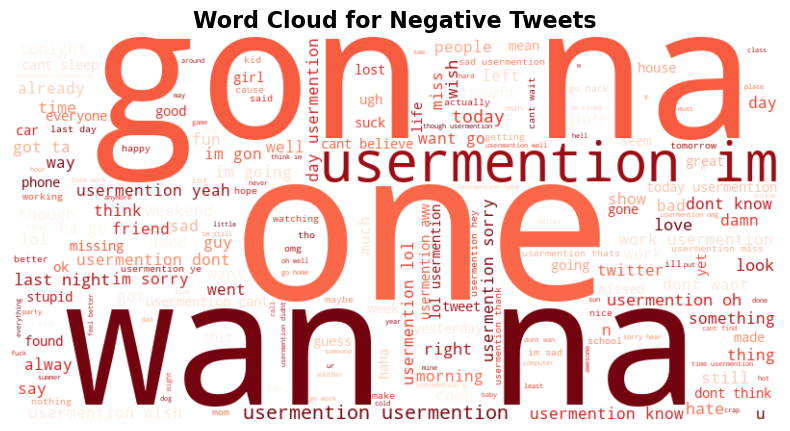

In [16]:
# Negative Tweets word cloud

# Filter only negative tweets (target == 0)
negative_tweets = preprocessed_tweets[preprocessed_tweets['target'] == 0]['text']

# Combine all negative tweet text into a single string
text_blob = ' '.join(negative_tweets.astype(str))

# Generate word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Reds',
    max_words=200
).generate(text_blob)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Negative Tweets", fontsize=16, fontweight='bold')
plt.show()

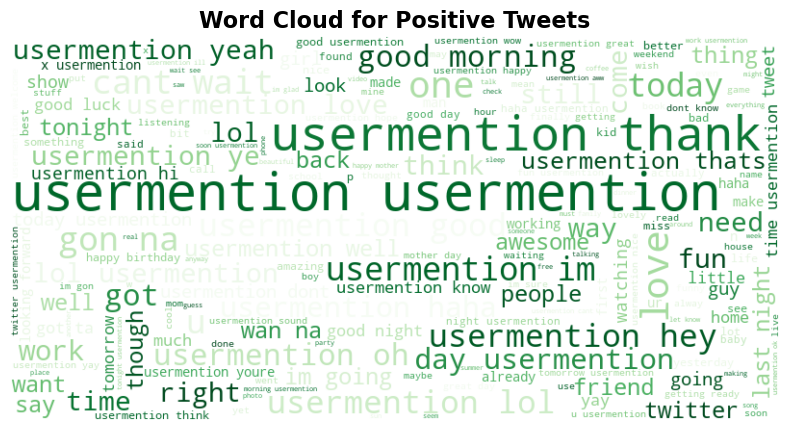

In [17]:
# Positive Tweets word cloud

# Filter only positive tweets (target == 4)
positive_tweets = preprocessed_tweets[preprocessed_tweets['target'] == 4]['text']

# Combine all negative tweet text into a single string
text_blob = ' '.join(positive_tweets.astype(str))

# Generate word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Greens',
    max_words=200
).generate(text_blob)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Positive Tweets", fontsize=16, fontweight='bold')
plt.show()

In [18]:
# We now save the processed tweets to be used later in model development

"""
# Step 1: Save file inside Colab
processed_data_dir = "/content"  # Best practice for Colab
output_processed_file_path = os.path.join(processed_data_dir, 'preprocessed_tweets.csv')
preprocessed_tweets.to_csv(output_processed_file_path, index=False)

print(f"Preprocessed tweets saved to: {output_processed_file_path}")

# Step 2: Download Mac Downloads folder manually
files.download(output_processed_file_path)
"""

print("Save processed file in github as it is less than 100MB")

Save processed file in github as it is less than 100MB


In [ ]:
processed_data_dir = "../processed_data"
os.makedirs(processed_data_dir, exist_ok=True)

output_processed_file_path = os.path.join(processed_data_dir, "preprocessed_tweets.csv")
preprocessed_tweets.to_csv(output_processed_file_path, index=False)

print(f"Preprocessed tweets saved to: {output_processed_file_path}")

#### Next we take first 70% of each negative and positive tweets for training, 15% for validation, and 15% for testing.
Sampling sould be done in a way that respects tweets length distribution.

This way we make sure all models are trained and validated using the same dataset and we have a good ground for fair comparison.

This step is valid because we showed in EDA section that negative and positive tewwts are equally distributed.

In [ ]:
# Here, we begin by loading the processed dataset

os.makedirs("../data", exist_ok=True)

file_id = "1LiS2ltl2XfITCamIrERkaa69OKKKoR_r"
url = f"https://drive.google.com/uc?id={file_id}"
output = "../data/preprocessed_tweets.csv"

gdown.download(url, output, quiet=False)

In [ ]:
# Read the preprocessed tweet dataset and assign column names
Tweets = pd.read_csv("../data/preprocessed_tweets.csv", header=None, names=["text", "target"])

# Drop any rows where 'text' or 'target' is null
Tweets = Tweets.dropna(subset=["text", "target"])

Tweets.head()

In [ ]:
# Define bins and labels from the bar chart in our EDA
bin_edges = [0, 20, 40, 60, 80, 100, 120, 140]
bin_labels = ['0–20', '21–40', '41–60', '61–80', '81–100', '101–120', '121–140']

# Step 1: Assign length buckets safely
def assign_length_buckets(df):
    df = df.copy()
    df['text'] = df['text'].fillna('').astype(str)  # Ensure no NaNs
    df['text_length'] = df['text'].str.len()
    df['length_bucket'] = pd.cut(
        df['text_length'],
        bins=bin_edges,
        labels=bin_labels,
        right=True,
        include_lowest=True
    )
    df = df.dropna(subset=['length_bucket'])  # Drop any that didn't fall in bin
    return df

# Step 2: Stratified split function
def stratified_split_by_length_bucket(df_class, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    df_class = assign_length_buckets(df_class)

    # Split into train and temp
    train_df, temp_df = train_test_split(
        df_class,
        test_size=1 - train_ratio,
        stratify=df_class['length_bucket'],
        random_state=42
    )

    # Split temp into validation and test
    val_ratio_adjusted = val_ratio / (val_ratio + test_ratio)
    val_df, test_df = train_test_split(
        temp_df,
        test_size=1 - val_ratio_adjusted,
        stratify=temp_df['length_bucket'],
        random_state=42
    )

    return train_df.drop(columns='length_bucket'), val_df.drop(columns='length_bucket'), test_df.drop(columns='length_bucket')

# Step 3: Filter by sentiment
df_neg = Tweets[Tweets['target'] == 0]
df_pos = Tweets[Tweets['target'] == 4]

# Step 4: Apply stratified splitting
neg_train, neg_val, neg_test = stratified_split_by_length_bucket(df_neg)
pos_train, pos_val, pos_test = stratified_split_by_length_bucket(df_pos)

# Step 5: Combine and shuffle
train_df = pd.concat([neg_train, pos_train]).sample(frac=1, random_state=42).reset_index(drop=True)
val_df = pd.concat([neg_val, pos_val]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([neg_test, pos_test]).sample(frac=1, random_state=42).reset_index(drop=True)

# Step 6: Extract input and labels
X_train = train_df['text']
y_train = train_df['target']
X_val = val_df['text']
y_val = val_df['target']
X_test = test_df['text']
y_test = test_df['target']

# Final check
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)
print("X_train shape:", X_train.shape, "| y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "| y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape, "| y_test shape:", y_test.shape)


In [ ]:
# here we validate the distributions are identical and intact

# Combine text + label for plotting, and calculate text length
train_plot_df = pd.concat([X_train, y_train], axis=1).copy()
val_plot_df = pd.concat([X_val, y_val], axis=1).copy()
test_plot_df = pd.concat([X_test, y_test], axis=1).copy()

# Ensure text_length column is present
train_plot_df['text_length'] = train_plot_df['text'].str.len()
val_plot_df['text_length'] = val_plot_df['text'].str.len()
test_plot_df['text_length'] = test_plot_df['text'].str.len()

# Ensure 'target' is integer (not string) for palette mapping
train_plot_df['target'] = train_plot_df['target'].astype(int)
val_plot_df['target'] = val_plot_df['target'].astype(int)
test_plot_df['target'] = test_plot_df['target'].astype(int)

# Define sentiment color palette
sentiment_palette = {
    0: '#fc8d62',  # Negative
    4: '#66c2a5'   # Positive
}

# Set up subplot layout
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot train
sns.violinplot(ax=axes[0], data=train_plot_df, x='target', y='text_length', hue='target', palette=sentiment_palette, inner='quartile', legend=False)
axes[0].set_title('Train Set')
axes[0].set_xlabel('Sentiment')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Negative (0)', 'Positive (4)'])

# Plot validation
sns.violinplot(ax=axes[1], data=val_plot_df, x='target', y='text_length', hue='target', palette=sentiment_palette, inner='quartile', legend=False)
axes[1].set_title('Validation Set')
axes[1].set_xlabel('Sentiment')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Negative (0)', 'Positive (4)'])

# Plot test
sns.violinplot(ax=axes[2], data=test_plot_df, x='target', y='text_length', hue='target', palette=sentiment_palette, inner='quartile', legend=False)
axes[2].set_title('Test Set')
axes[2].set_xlabel('Sentiment')
axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(['Negative (0)', 'Positive (4)'])

# Shared Y-label and layout
fig.supylabel('Tweet Length (characters)', fontsize=12)
plt.suptitle("Tweet Length Distribution by Sentiment Across Splits", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### After we made sure we have good and valid splits, we now move on to modeling part, where we will only use training and validation set for model comparison and selection, ***testing dataset will only be used in model performance evaluation section***

In [ ]:
# Finally, we save splits as CSV to ensure no data leakage takes place as differnt team members split and train the models. this way everyone uses the same training dataset.

import os
import zipfile
import pandas as pd

# Step 1: Save splits locally (optional for inspection or reuse)
train_df.to_csv("train_dataset.csv", index=False)
val_df.to_csv("val_dataset.csv", index=False)
test_df.to_csv("test_dataset.csv", index=False)

# Step 2: Offer download in Colab (optional)
try:
    from google.colab import files
    files.download("train_dataset.csv")
    files.download("val_dataset.csv")
    files.download("test_dataset.csv")
except ImportError:
    print("Not running in Google Colab. Local files saved.")

# Step 3: Save processed datasets to GitHub repo structure
print("Saving split datasets and compressed archive in repository...")

processed_data_dir = "../processed_data" if os.path.exists("../processed_data") else "processed_data"
os.makedirs(processed_data_dir, exist_ok=True)

# Paths to save the individual files
train_path = os.path.join(processed_data_dir, "train_dataset.csv")
val_path = os.path.join(processed_data_dir, "val_dataset.csv")
test_path = os.path.join(processed_data_dir, "test_dataset.csv")

# Save to processed_data/
train_df.to_csv(train_path, index=False)
val_df.to_csv(val_path, index=False)
test_df.to_csv(test_path, index=False)

# Step 4: Create a zip archive of the datasets
zip_path = os.path.join(processed_data_dir, "sentiment140_splits.zip")
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(train_path, arcname="train_dataset.csv")
    zipf.write(val_path, arcname="val_dataset.csv")
    zipf.write(test_path, arcname="test_dataset.csv")

print(f"Zipped dataset saved to: {zip_path}")
print("Contents of archive:")
with zipfile.ZipFile(zip_path, 'r') as zipf:
    print(zipf.namelist())

print("\n📦 Ready to commit the archive to your GitHub repository:")
print(f"cd to repo folder and run:\n")
print(f"git add {zip_path}")
print(f'git commit -m "Add compressed dataset splits for reproducibility"')
print("git push")
